In [1]:
import numpy as np 
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data preparation

In [3]:
import pickle 

# Load
with open('Data/nfl_train_test_data.pkl', 'rb') as f:
    data = pickle.load(f)
    X_train = data['X_train']
    Y_train = data['Y_train']
    Y_train_noised = data['Y_train_noised']
    Y_noise_train = data['Y_noise_train']
    X_noise_train = data['X_noise_train']
    X_test = data['X_test']
    Y_test = data['Y_test']
    Y_test_noised = data['Y_test_noised']
    Y_noise_test = data['Y_noise_test']
    X_noise_test = data['X_noise_test']
    Data_train = data['Data_train']
    Data_test = data['Data_test']

In [4]:
from Scripts.Data.NFL_data_preprocessing import normalization


X_train_normalized, Y_train_normalized, Y_train_noised_normalized, Y_noise_train_normalized, X_noise_train_normalized, X_test_normalized, Y_test_normalized, Y_test_noised_normalized, Y_noise_test_normalized, X_noise_test_normalized, Data_train_normalized, Data_test_normalized, scaler_x, scaler_y, scaler_y_noised, scaler_y_noise, scaler_x_noise, scaler_data = normalization(X_train, Y_train, Y_train_noised, Y_noise_train, X_noise_train, X_test, Y_test, Y_test_noised, Y_noise_test, X_noise_test, Data_train, Data_test) 



# Models Training

## LSTM

In [5]:
from Scripts.Results.Metrics.Evaluation_Metrics import train_lstm
from Scripts.Models.LSTM2 import LSTMModel

input_size = list(X_train_normalized.values())[0].shape[2]
output_size = list(Y_train_normalized.values())[0].shape[2]
hidden_size = 256
num_layers = 4
bidirectional = True
lstm_model = LSTMModel(input_size, hidden_size, output_size, num_layers, bidirectional)
model = lstm_model
batch_size = 32
learning_rate = 0.001
epochs = 10

train_lstm(model, X_train_normalized, Y_train_normalized, epochs, learning_rate, batch_size, X_test_normalized, Y_test_normalized, model_name='./Visualization/Results/lstm_model.pt')

Epoch 1/10, Train Loss: 2.7605, Test Loss: 2.6232,  Time: 526.0052s
Epoch 2/10, Train Loss: 2.7079, Test Loss: 2.6269,  Time: 518.0449s
Epoch 3/10, Train Loss: 2.6979, Test Loss: 2.6349,  Time: 528.2556s
Epoch 4/10, Train Loss: 2.6912, Test Loss: 2.6229,  Time: 529.3192s
Epoch 5/10, Train Loss: 2.6354, Test Loss: 2.4907,  Time: 530.5781s
Epoch 6/10, Train Loss: 2.5585, Test Loss: 2.4430,  Time: 490.4206s
Epoch 7/10, Train Loss: 2.5270, Test Loss: 2.4201,  Time: 490.3942s
Epoch 8/10, Train Loss: 2.5043, Test Loss: 2.4204,  Time: 471.9423s
Epoch 9/10, Train Loss: 2.4897, Test Loss: 2.4181,  Time: 475.5805s
Epoch 10/10, Train Loss: 2.4736, Test Loss: 2.4148,  Time: 499.5678s


In [6]:
from sklearn.metrics import mean_squared_error, r2_score

# Test the model on the test set
lstm_model.load_state_dict(torch.load('./Visualization/Results/lstm_model.pt'))
lstm_model.eval()
test_loss = 0.0
criterion = nn.MSELoss()
with torch.no_grad():
    for test_game, x_test in X_test_normalized.items():
        y_test = Y_test_normalized[test_game]  # Use the actual trajectory as the target
        output = lstm_model(x_test)
        loss = criterion(output, y_test)  # Use the actual trajectory as the target
        test_loss += loss.item()

test_loss /= len(X_test)
print(f'Test Loss: {test_loss:.4f}')

# Analyze the predictions on the test set
predicted_trajectories = []
actual_trajectories = []
with torch.no_grad():
    for test_game, x_test in X_test_normalized.items():
        y_test = Y_test_normalized[test_game]  # Use the actual trajectory as the target
        output = lstm_model(x_test)
        predicted_trajectories.append(output.detach().numpy().reshape(-1, output.shape[-1]))
        actual_trajectories.append(y_test.numpy().reshape(-1, y_test.shape[-1]))

# Flatten the predicted trajectories and actual trajectories for analysis
predicted_trajectories = np.concatenate(predicted_trajectories)
actual_trajectories = np.concatenate(actual_trajectories)

# Calculate the mean squared error and R^2 score
mse = mean_squared_error(actual_trajectories, predicted_trajectories)
r2 = r2_score(actual_trajectories, predicted_trajectories)
print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

Test Loss: 0.4596
Mean Squared Error: 0.4546
R^2 Score: 0.1288


In [15]:
from Scripts.Results.Metrics.Evaluation_Metrics import min_ade23, min_fde23

# Generate multiple predicted trajectories for each input sequence
num_samples = 100
pred_trajs_list = []
with torch.no_grad():
    for test_game, x_test in X_test_normalized.items():
        pred_trajs = []
        for _ in range(num_samples):
            output = lstm_model(x_test)
            pred_trajs.append(output.detach().cpu().numpy())
        pred_trajs_list.append(pred_trajs)

# Compute minADE23 and minFDE23 for each input sequence
min_ade23_list = []
min_fde23_list = []
for pred_trajs, gt_traj in zip(pred_trajs_list, Y_test_normalized.values()):  # Use the actual trajectory as the target
    gt_traj = gt_traj.detach().cpu().numpy()
    min_ade23_ = min_ade23(pred_trajs, gt_traj)
    min_fde23_ = min_fde23(pred_trajs, gt_traj)
    min_ade23_list.append(min_ade23_)
    min_fde23_list.append(min_fde23_)

# Compute average minADE23 and minFDE23 over all input sequences
avg_min_ade23 = np.mean(min_ade23_list)
avg_min_fde23 = np.mean(min_fde23_list)

print(f'minADE23: {avg_min_ade23:.4f}, minFDE23: {avg_min_fde23:.4f}')

minADE23: 0.3641, minFDE23: 0.3343


## RNN



In [7]:
from Scripts.Results.Metrics.Evaluation_Metrics import train_lstm
from Scripts.Models.RNN import RNNModel

input_size = list(X_train_normalized.values())[0].shape[2]
output_size = list(Y_train_normalized.values())[0].shape[2]
hidden_size = 256
num_layers = 2
bidirectional = True
rnn_model = RNNModel(input_size, hidden_size, output_size, num_layers, bidirectional)
model = rnn_model
batch_size = 32
learning_rate = 0.001
epochs = 10

train_lstm(model, X_train_normalized, Y_train_normalized, epochs, learning_rate, batch_size, X_test_normalized, Y_test_normalized, model_name='./Visualization/Results/rnn_model.pt')

C:\Users\spman\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/10, Train Loss: 10.3002, Test Loss: 9.0256,  Time: 275.4090s
Epoch 2/10, Train Loss: 8.9506, Test Loss: 8.4206,  Time: 272.8864s
Epoch 3/10, Train Loss: 8.7575, Test Loss: 7.0631,  Time: 279.4248s
Epoch 4/10, Train Loss: 8.0383, Test Loss: 7.5406,  Time: 263.3102s
Epoch 5/10, Train Loss: 7.4185, Test Loss: 6.5523,  Time: 262.4355s
Epoch 6/10, Train Loss: 7.7032, Test Loss: 8.7344,  Time: 248.1416s
Epoch 7/10, Train Loss: 7.2302, Test Loss: 7.8333,  Time: 239.5296s
Epoch 8/10, Train Loss: 7.5277, Test Loss: 6.4970,  Time: 236.3636s
Epoch 9/10, Train Loss: 7.4817, Test Loss: 7.1263,  Time: 236.2408s
Epoch 10/10, Train Loss: 7.7854, Test Loss: 6.7478,  Time: 235.3442s


In [8]:
from sklearn.metrics import mean_squared_error, r2_score

# Test the model on the test set
rnn_model.load_state_dict(torch.load('./Visualization/Results/rnn_model.pt'))
rnn_model.eval()
test_loss = 0.0
criterion = nn.MSELoss()
with torch.no_grad():
    for test_game, x_test in X_test_normalized.items():
        y_test = Y_test_normalized[test_game]
        output = rnn_model(x_test)
        predicted_noise = x_test - output
        loss = criterion(predicted_noise, y_test)
        test_loss += loss.item()

test_loss /= len(X_test)
print(f'Test Loss: {test_loss:.4f}')

# Analyze the predictions on the test set
predicted_noises = []
actual_noises = []
with torch.no_grad():
    for test_game, x_test in X_test_normalized.items():
        y_test = Y_test_normalized[test_game]
        output = rnn_model(x_test)
        predicted_noise = x_test - output
        predicted_noises.append(predicted_noise.detach().numpy().reshape(-1, output.shape[-1]))
        actual_noises.append(y_test.numpy().reshape(-1, y_test.shape[-1]))

# Flatten the predicted noises and actual noises for analysis
predicted_noises = np.concatenate(predicted_noises)
actual_noises = np.concatenate(actual_noises)

# Calculate the mean squared error and R^2 score
mse = mean_squared_error(actual_noises, predicted_noises)
r2 = r2_score(actual_noises, predicted_noises)
print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

Test Loss: 1.4010
Mean Squared Error: 1.4148
R^2 Score: -0.4148


In [9]:
from Scripts.Results.Metrics.Evaluation_Metrics import min_ade23, min_fde23

# Generate multiple predicted trajectories for each input sequence
num_samples = 100
pred_trajs_list = []
with torch.no_grad():
    for test_game, x_test in X_test_normalized.items():
        pred_trajs = []
        for _ in range(num_samples):
            output = rnn_model(x_test)
            pred_trajs.append(output.detach().cpu().numpy())
        pred_trajs_list.append(pred_trajs)

# Compute minADE23 and minFDE23 for each input sequence
min_ade23_list = []
min_fde23_list = []
for pred_trajs, gt_traj in zip(pred_trajs_list, X_test_normalized.values()):
    gt_traj = gt_traj.detach().cpu().numpy()
    min_ade23_ = min_ade23(pred_trajs, gt_traj)
    min_fde23_ = min_fde23(pred_trajs, gt_traj)
    min_ade23_list.append(min_ade23_)
    min_fde23_list.append(min_fde23_)

# Compute average minADE23 and minFDE23 over all input sequences
avg_min_ade23 = np.mean(min_ade23_list)
avg_min_fde23 = np.mean(min_fde23_list)

print(f'minADE23: {avg_min_ade23:.4f}, minFDE23: {avg_min_fde23:.4f}')

minADE23: 0.9167, minFDE23: 0.6193


## Diffusion Transformer

In [5]:
from Scripts.Results.Metrics.Evaluation_Metrics import train_lstm
from Scripts.Models.DiffTransformer import DiffusionTransformer

input_size = 12
output_size = 12
num_layers = 2
dropout = 0.1
hidden_size = 512
max_len = 5000
epochs = 10
learning_rate = 0.001
batch_size = 32


difftransformer_model = DiffusionTransformer(d_model=input_size, nhead=4, num_encoder_layers=num_layers, d_ff=hidden_size, dropout=dropout, max_len=max_len)
model = difftransformer_model

train_lstm(model, X_train_normalized, Y_train_normalized, epochs, learning_rate, batch_size, X_test_normalized, Y_test_normalized, model_name='./Visualization/Results/difftransformer_model.pt')

C:\Users\spman\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/10, Train Loss: 9.8245, Test Loss: 8.7430,  Time: 92.2837s
Epoch 2/10, Train Loss: 8.9041, Test Loss: 8.3375,  Time: 68.9047s
Epoch 3/10, Train Loss: 8.6427, Test Loss: 8.1882,  Time: 69.4913s
Epoch 4/10, Train Loss: 8.5229, Test Loss: 8.1702,  Time: 68.8312s
Epoch 5/10, Train Loss: 8.4407, Test Loss: 8.1828,  Time: 67.9598s
Epoch 6/10, Train Loss: 8.3811, Test Loss: 8.1463,  Time: 69.1686s
Epoch 7/10, Train Loss: 8.3306, Test Loss: 8.0784,  Time: 70.0072s
Epoch 8/10, Train Loss: 8.2873, Test Loss: 8.0123,  Time: 67.3562s
Epoch 9/10, Train Loss: 8.2479, Test Loss: 8.0023,  Time: 67.2200s
Epoch 10/10, Train Loss: 8.2159, Test Loss: 7.9893,  Time: 68.4607s


In [6]:
from sklearn.metrics import mean_squared_error, r2_score

# Test the model on the test set
difftransformer_model.load_state_dict(torch.load('./Visualization/Results/difftransformer_model.pt'))
difftransformer_model.eval()
test_loss = 0.0
criterion = nn.MSELoss()
with torch.no_grad():
    for test_game, x_test in X_test_normalized.items():
        y_test = Y_test_normalized[test_game]
        output = difftransformer_model(x_test)
        predicted_noise = x_test - output
        loss = criterion(predicted_noise, y_test)
        test_loss += loss.item()

test_loss /= len(X_test)
print(f'Test Loss: {test_loss:.4f}')

# Analyze the predictions on the test set
predicted_noises = []
actual_noises = []
with torch.no_grad():
    for test_game, x_test in X_test_normalized.items():
        y_test = Y_test_normalized[test_game]
        output = difftransformer_model(x_test)
        predicted_noise = x_test - output
        predicted_noises.append(predicted_noise.detach().numpy().reshape(-1, output.shape[-1]))
        actual_noises.append(y_test.numpy().reshape(-1, y_test.shape[-1]))

# Flatten the predicted noises and actual noises for analysis
predicted_noises = np.concatenate(predicted_noises)
actual_noises = np.concatenate(actual_noises)

# Calculate the mean squared error and R^2 score
mse = mean_squared_error(actual_noises, predicted_noises)
r2 = r2_score(actual_noises, predicted_noises)
print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

Test Loss: 1.0652
Mean Squared Error: 1.0773
R^2 Score: -0.0773


In [8]:
from Scripts.Results.Metrics.Evaluation_Metrics import min_ade23, min_fde23

# Generate multiple predicted trajectories for each input sequence
num_samples = 100
pred_trajs_list = []
with torch.no_grad():
    for test_game, x_test in X_test_normalized.items():
        pred_trajs = []
        for _ in range(num_samples):
            output = difftransformer_model(x_test)
            pred_trajs.append(output.detach().cpu().numpy())
        pred_trajs_list.append(pred_trajs)

# Compute minADE23 and minFDE23 for each input sequence
min_ade23_list = []
min_fde23_list = []
for pred_trajs, gt_traj in zip(pred_trajs_list, X_test_normalized.values()):
    gt_traj = gt_traj.detach().cpu().numpy()
    min_ade23_ = min_ade23(pred_trajs, gt_traj)
    min_fde23_ = min_fde23(pred_trajs, gt_traj)
    min_ade23_list.append(min_ade23_)
    min_fde23_list.append(min_fde23_)

# Compute average minADE23 and minFDE23 over all input sequences
avg_min_ade23 = np.mean(min_ade23_list)
avg_min_fde23 = np.mean(min_fde23_list)

print(f'minADE23: {avg_min_ade23:.4f}, minFDE23: {avg_min_fde23:.4f}')

minADE23: 0.6423, minFDE23: 0.6137


## Social Diffusion Transformer

In [5]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

from Scripts.Results.Metrics.Evaluation_Metrics import train_diff
from Scripts.Models.SocialDiffTransformer import DiffusionTransformer

input_size = list(X_train_normalized.values())[0].shape[2]
output_size = list(Y_train_normalized.values())[0].shape[2]
hidden_size = 1024
num_layers = 4
nhead = 6
dropout = 0.2
max_len = 5000
model = DiffusionTransformer(d_model=input_size, nhead=nhead, num_encoder_layers=num_layers, d_ff=hidden_size, dropout=dropout, max_len=max_len)

batch_size = 32
learning_rate = 0.001
epochs = 20

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)

model.train()
best_val_loss = float('inf')
no_improvement = 0
patience = 3


for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0.0
    for df_name, x in X_train_normalized.items():
        y = Y_train_normalized[df_name]
        y_noised = Y_train_noised_normalized[df_name]
        y_noise = Y_noise_train_normalized[df_name]
        for i in range(0, len(x), batch_size):
            optimizer.zero_grad()
            batch_x = x[i:i+batch_size]
            batch_y = y[i:i+batch_size]
            batch_y_noised = y_noised[i:i+batch_size]
            batch_y_noise = y_noise[i:i+batch_size]
            output = model(batch_x, batch_y_noised)
            loss = criterion(output, batch_y_noise)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

    train_loss /= len(X_train)

    # Evaluation on the test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for test_game, x in X_test_normalized.items():
            x = X_test_normalized[test_game]
            y = Y_test_normalized[test_game]
            y_noised = Y_test_noised_normalized[test_game]
            y_noise = Y_noise_test_normalized[test_game]
            for i in range(0, len(x), batch_size):
                batch_x = x[i:i+batch_size]
                batch_y = y[i:i+batch_size]
                batch_y_noised = y_noised[i:i+batch_size]
                batch_y_noise = y_noise[i:i+batch_size]
                output = model(batch_x, batch_y_noised)
                loss = criterion(output, batch_y_noise)

                test_loss += loss.item()

        test_loss /= len(X_test)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f},  Time: {time.time() - start_time:.4f}s")

    if test_loss < best_val_loss:
        best_val_loss = test_loss
        no_improvement = 0
        torch.save(model.state_dict(), './Visualization/Results/socialdiff_model.pt')
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    scheduler.step(test_loss)

model.eval()

Epoch 1/20, Train Loss: 1.7790, Test Loss: 0.9644,  Time: 185.1057s
Epoch 2/20, Train Loss: 0.9738, Test Loss: 0.7741,  Time: 180.5133s
Epoch 3/20, Train Loss: 0.8476, Test Loss: 0.7145,  Time: 189.8940s
Epoch 4/20, Train Loss: 0.8000, Test Loss: 0.6806,  Time: 183.7278s
Epoch 5/20, Train Loss: 0.7740, Test Loss: 0.6612,  Time: 184.2729s
Epoch 6/20, Train Loss: 0.7569, Test Loss: 0.6480,  Time: 182.0228s
Epoch 7/20, Train Loss: 0.7436, Test Loss: 0.6370,  Time: 180.8230s
Epoch 8/20, Train Loss: 0.7340, Test Loss: 0.6280,  Time: 181.4730s
Epoch 9/20, Train Loss: 0.7259, Test Loss: 0.6233,  Time: 173.7673s
Epoch 10/20, Train Loss: 0.7199, Test Loss: 0.6168,  Time: 170.4898s
Epoch 11/20, Train Loss: 0.7145, Test Loss: 0.6137,  Time: 173.1654s
Epoch 12/20, Train Loss: 0.7095, Test Loss: 0.6104,  Time: 190.3090s
Epoch 13/20, Train Loss: 0.7051, Test Loss: 0.6096,  Time: 175.9126s
Epoch 14/20, Train Loss: 0.7013, Test Loss: 0.6066,  Time: 173.5680s
Epoch 15/20, Train Loss: 0.6983, Test Loss:

DiffusionTransformer(
  (pos_encoding): RotaryPositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (social_encoder): SocialEncoder(
    (linear_q): Linear(in_features=12, out_features=12, bias=True)
    (linear_k): Linear(in_features=12, out_features=12, bias=True)
    (linear_v): Linear(in_features=12, out_features=12, bias=True)
    (linear_out): Linear(in_features=12, out_features=12, bias=True)
    (attention): MultiHeadAttention(
      (linear_q): Linear(in_features=12, out_features=12, bias=True)
      (linear_k): Linear(in_features=12, out_features=12, bias=True)
      (linear_v): Linear(in_features=12, out_features=12, bias=True)
      (linear_out): Linear(in_features=12, out_features=12, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (feedforward): FeedForward(
      (linear1): Linear(in_features=12, out_features=48, bias=True)
      (linear2): Linear(in_features=48, out_features=12, bias=True)
      (dropout): Dropout(p=0.1, inplace=Fals

In [5]:
from Scripts.Models.SocialDiffTransformer import DiffusionTransformer

input_size = list(X_train_normalized.values())[0].shape[2]
output_size = list(Y_train_normalized.values())[0].shape[2]
hidden_size = 1024
num_layers = 4
nhead = 6
dropout = 0.2
max_len = 5000
model = DiffusionTransformer(d_model=input_size, nhead=nhead, num_encoder_layers=num_layers, d_ff=hidden_size, dropout=dropout, max_len=max_len)

batch_size = 32
learning_rate = 0.001
epochs = 20

In [6]:
from sklearn.metrics import mean_squared_error, r2_score

# Test the model on the test set
model.load_state_dict(torch.load('./Visualization/Results/socialdiff_model.pt'))
model.eval()
test_loss = 0.0
criterion = nn.MSELoss()
with torch.no_grad():
    for test_game, x_test in X_test_normalized.items():
        y_test = Y_test_normalized[test_game]
        y_test_noised = Y_test_noised_normalized[test_game]
        y_noise_test = Y_noise_test_normalized[test_game]
        output = model(x_test, y_test_noised)
        loss = criterion(output, y_noise_test)
        test_loss += loss.item()

test_loss /= len(X_test)
print(f'Test Loss: {test_loss:.4f}')

# Analyze the predictions on the test set
predicted_noises = []
actual_noises = []
with torch.no_grad():
    for test_game, x_test in X_test_normalized.items():
        y_test = Y_test_normalized[test_game]
        y_test_noised = Y_test_noised_normalized[test_game]
        y_noise_test = Y_noise_test_normalized[test_game]
        output = model(x_test, y_test_noised)
        predicted_noise = output
        predicted_noises.append(predicted_noise.detach().numpy().reshape(-1, output.shape[-1]))
        actual_noises.append(y_noise_test.numpy().reshape(-1, y_test.shape[-1]))

# Flatten the predicted noises and actual noises for analysis
predicted_noises = np.concatenate(predicted_noises)
actual_noises = np.concatenate(actual_noises)

# Calculate the mean squared error and R^2 score
mse = mean_squared_error(actual_noises, predicted_noises)
r2 = r2_score(actual_noises, predicted_noises)
print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

Test Loss: 0.1179
Mean Squared Error: 0.1151
R^2 Score: 0.8015


In [7]:
from Scripts.Results.Metrics.Evaluation_Metrics import min_ade20, min_fde20, reverse_diffusion_process


num_samples = 400

# Calculate minADE23 and minFDE23
min_ade20_list, min_fde20_list = [], []
generated_trajectories = {}
for test_game, x_test in X_test_normalized.items():
    y_test = Y_test_normalized[test_game]
    y_test_noised = Y_test_noised_normalized[test_game]
    output = model(x_test, y_test_noised)
    noise_predictions = output.detach().cpu().numpy()
    pred_trajs = []
    for _ in range(num_samples):
        y_pred = reverse_diffusion_process(model, y_test_noised, noise_predictions)
        pred_trajs.append(y_pred.detach().cpu().numpy())
    gt_traj = y_test.detach().cpu().numpy()
    min_ade20_ = min_ade20(pred_trajs, gt_traj)
    min_fde20_ = min_fde20(pred_trajs, gt_traj)
    min_ade20_list.append(min_ade20_)
    min_fde20_list.append(min_fde20_)
    generated_trajectories[test_game] = np.mean(pred_trajs, axis=0)

avg_min_ade20 = np.mean(min_ade20_list)
avg_min_fde20 = np.mean(min_fde20_list)
print(f'minADE20: {avg_min_ade20:.4f}, minFDE20: {avg_min_fde20:.4f}')


minADE20: 0.8088, minFDE20: 0.5246


Plotting game: 2019_WAS_2019090806_193


IndexError: index 23 is out of bounds for dimension 1 with size 23

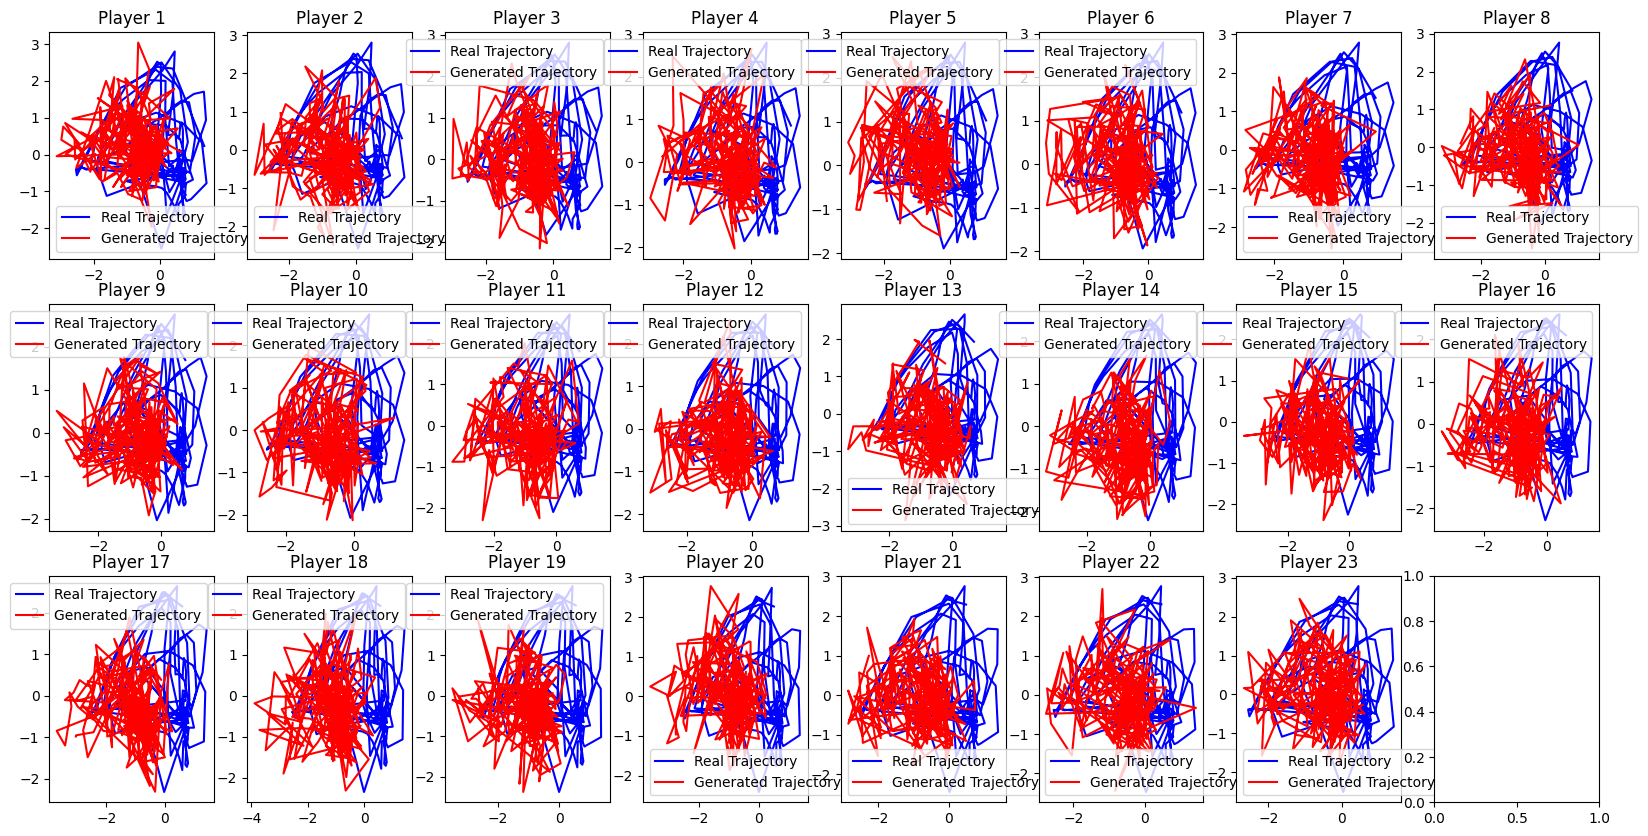

In [17]:
from Scripts.Results.Metrics.Evaluation_Metrics import min_ade20, min_fde20, reverse_diffusion_process

num_samples = 100

# Loop over test games
generated_trajectories = {}
for test_game, x_test in X_test_normalized.items():
    print(f"Plotting game: {test_game}")
    y_test = Y_test_normalized[test_game]
    y_test_noised = Y_test_noised_normalized[test_game]
    output = model(x_test, y_test_noised)
    noise_predictions = output.detach().cpu().numpy()
    pred_trajs = []
    for _ in range(num_samples):
        y_pred = reverse_diffusion_process(model, y_test_noised, noise_predictions)
        pred_trajs.append(y_pred.detach().cpu().numpy())
    gt_traj = y_test.detach().cpu().numpy()
    generated_trajectories[test_game] = pred_trajs

    # Plot real trajectory vs generated trajectory for each player in the current game
    fig, axs = plt.subplots(nrows=3, ncols=8, figsize=(20, 10))
    for i, ax in enumerate(axs.flat):
        if i >= len(y_test):
            break
        # Get ground truth and generated trajectories for the i-th player
        gt_traj = y_test[:,i,:].squeeze().detach().cpu().numpy()
        pred_trajs = [pred_traj[:, i, :] for pred_traj in generated_trajectories[test_game]]
        pred_trajs = np.array(pred_trajs)

        # Find column numbers of 'x' and 'y'
        x_col = 3  # index of 'x' feature in the original selected_features list
        y_col = 4  # index of 'y' feature in the original selected_features list

        # Plot the trajectories
        ax.plot(gt_traj[:, x_col], gt_traj[:, y_col], label='Real Trajectory', color='blue')
        ax.plot(pred_trajs[:, :, x_col].mean(axis=0), pred_trajs[:, :, y_col].mean(axis=0), label='Generated Trajectory', color='red')
        ax.set_title(f'Player {i+1}')
        ax.legend()
    plt.tight_layout()
    plt.show()

Plotting game: 2019_WAS_2019090806_193


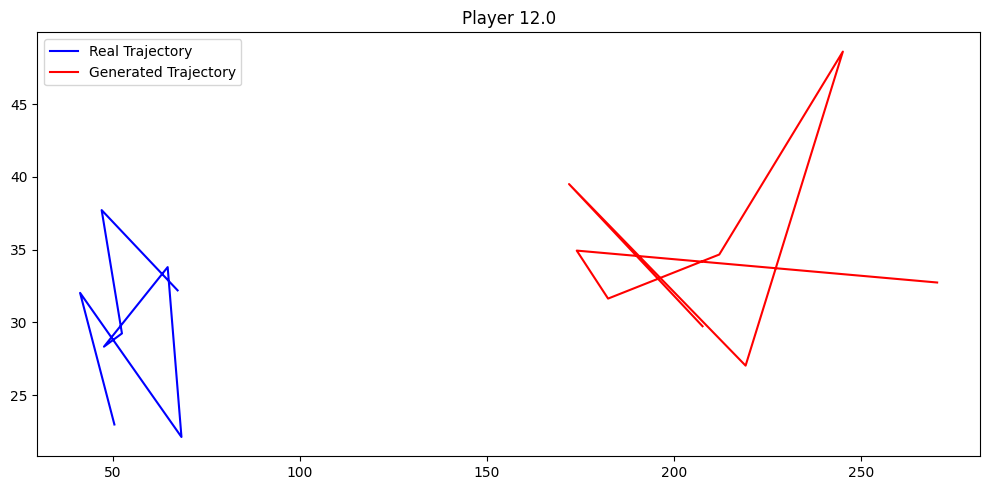

IndexError: boolean index did not match indexed array along dimension 0; dimension is 8 but corresponding boolean dimension is 223

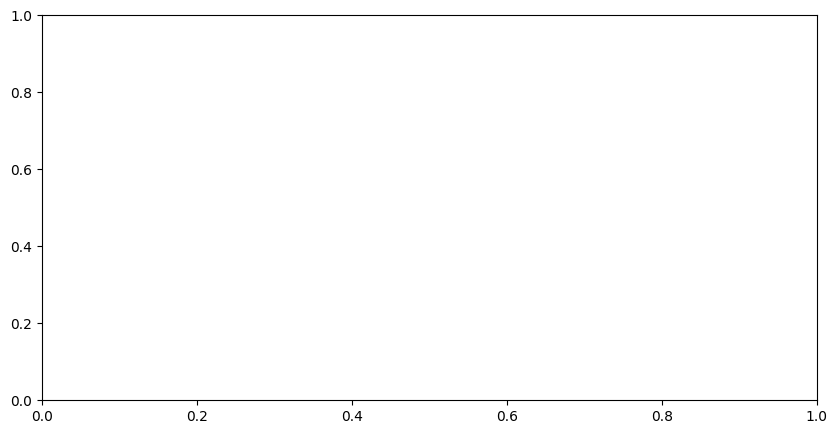

In [7]:
# Assuming mean_x, std_x are arrays containing the mean and standard deviation values for 'x' and 'y'
from Scripts.Results.Metrics.Evaluation_Metrics import min_ade20, min_fde20, reverse_diffusion_process

num_samples = 100

generated_trajectories = {}
for test_game, x_test in X_test.items():
    print(f"Plotting game: {test_game}")
    y_test = Y_test[test_game]
    y_test_noised = Y_test_noised[test_game]
    output = model(x_test, y_test_noised)
    noise_predictions = output.detach().cpu().numpy()
    pred_trajs = []
    for _ in range(num_samples):
        y_pred = reverse_diffusion_process(model, y_test_noised, noise_predictions)
        pred_trajs.append(y_pred.detach().cpu().numpy())
    gt_traj = y_test.detach().cpu().numpy()
    generated_trajectories[test_game] = np.mean(pred_trajs, axis=0)

    # Find unique player IDs in the current game
    player_ids = np.unique(x_test[:, :, 11])

    # Plot real trajectory vs generated trajectory for each player in the current game
    for player_id in player_ids:
        fig, ax = plt.subplots(figsize=(10, 5))  # Create a new figure for each player

        # Filter real and generated trajectories based on the player ID
        gt_traj = gt_traj[x_test[:, :, 11] == player_id]
        pred_trajs = generated_trajectories[test_game][x_test[:, :, 11] == player_id]

        denormalized_pred_trajs = pred_trajs.reshape(-1, pred_trajs.shape[-1]) * std_x.reshape(1, -1) + mean_x.reshape(1, -1)
        denormalized_pred_trajs = denormalized_pred_trajs.reshape(pred_trajs.shape)

        x_col = 3
        y_col = 4

        # Plot the trajectories
        ax.plot(gt_traj[:, x_col], gt_traj[:, y_col], label='Real Trajectory', color='blue')
        ax.plot(denormalized_pred_trajs[:, x_col], denormalized_pred_trajs[:, y_col], label='Generated Trajectory', color='red')
        ax.set_title(f'Player {player_id}')
        ax.legend()
        plt.tight_layout()
        plt.show()

Plotting game: 2019_WAS_2019090806_193
(223, 23, 12)


IndexError: boolean index did not match indexed array along dimension 2; dimension is 12 but corresponding boolean dimension is 223

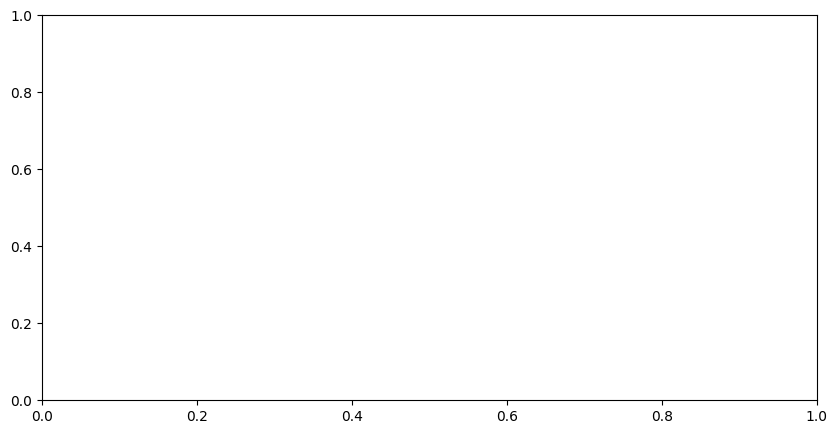

In [11]:
from Scripts.Results.Metrics.Evaluation_Metrics import min_ade20, min_fde20, reverse_diffusion_process

num_samples = 100

generated_trajectories = {}
for test_game, x_test in X_test.items():
    print(f"Plotting game: {test_game}")
    y_test = Y_test[test_game]
    y_test_noised = Y_test_noised[test_game]
    output = model(x_test, y_test_noised)
    noise_predictions = output.detach().cpu().numpy()
    pred_trajs = []
    for _ in range(num_samples):
        y_pred = reverse_diffusion_process(model, y_test_noised, noise_predictions)
        pred_trajs.append(y_pred.detach().cpu().numpy())
    gt_traj = y_test.detach().cpu().numpy()
    generated_trajectories[test_game] = np.mean(pred_trajs, axis=0)

    # Find unique player IDs in the current game
    player_ids = np.unique(x_test[:, :, 11])

    # Plot real trajectory vs generated trajectory for each player in the current game
    for player_id in player_ids:
        fig, ax = plt.subplots(figsize=(10, 5))  # Create a new figure for each player

        # Filter real and generated trajectories based on the player ID
        player_mask = x_test[:, :, 11] == player_id
        print(gt_traj.shape)
        gt_traj = gt_traj[:, :, player_mask.any(axis=1)]
        pred_trajs = generated_trajectories[test_game][:, :, player_mask.any(axis=1)]

        denormalized_pred_trajs = scaler_y.inverse_transform(pred_trajs.reshape(-1, pred_trajs.shape[-1])).reshape(pred_trajs.shape)

        x_col = 3
        y_col = 4

        # Plot the trajectories
        ax.plot(gt_traj[:, x_col], gt_traj[:, y_col], label='Real Trajectory', color='blue')
        ax.plot(denormalized_pred_trajs[:, x_col], denormalized_pred_trajs[:, y_col], label='Generated Trajectory', color='red')
        ax.set_title(f'Player {player_id}')
        ax.legend()
        plt.tight_layout()
        plt.show()


Plotting game: 2019_WAS_2019090806_193


IndexError: index 23 is out of bounds for dimension 1 with size 23

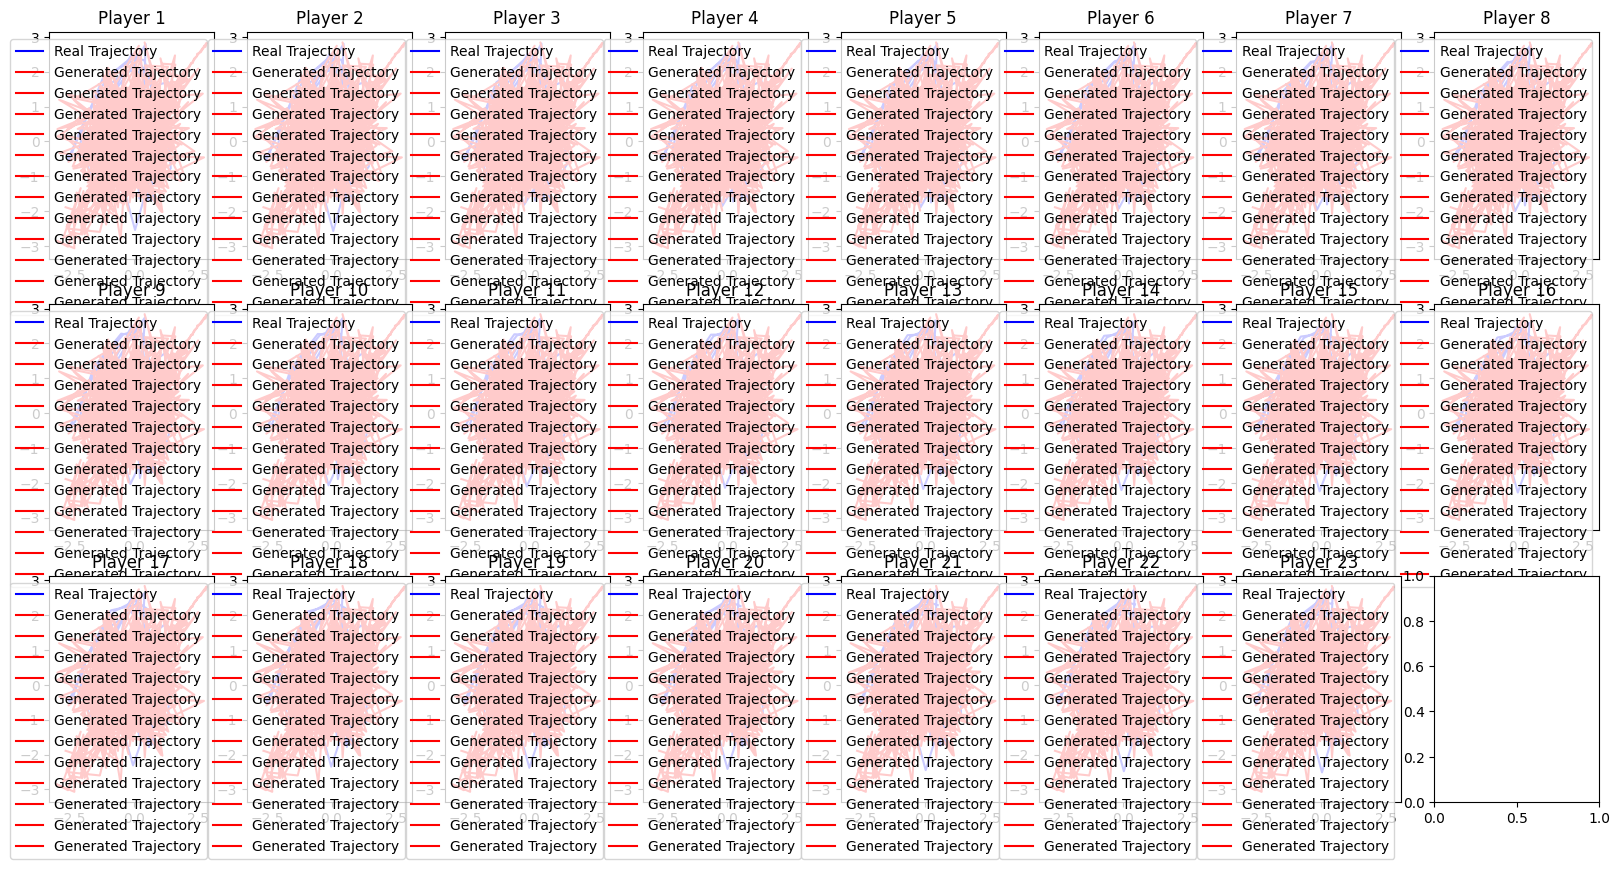

In [13]:
from Scripts.Results.Metrics.Evaluation_Metrics import min_ade20, min_fde20, reverse_diffusion_process

num_samples = 100

# Loop over test games
generated_trajectories = {}
for test_game, x_test in X_test_normalized.items():
    print(f"Plotting game: {test_game}")
    y_test = Y_test_normalized[test_game]
    y_test_noised = Y_test_noised_normalized[test_game]
    output = model(x_test, y_test_noised)
    noise_predictions = output.detach().cpu().numpy()
    pred_trajs = []
    for _ in range(num_samples):
        y_pred = reverse_diffusion_process(model, y_test_noised, noise_predictions)
        pred_trajs.append(y_pred.detach().cpu().numpy())
    gt_traj = y_test.detach().cpu().numpy()
    generated_trajectories[test_game] = np.mean(pred_trajs, axis=0)

    # Plot real trajectory vs generated trajectory for each player in the current game
    fig, axs = plt.subplots(nrows=3, ncols=8, figsize=(20, 10))
    for i, ax in enumerate(axs.flat):
        if i >= len(y_test):
            break
        # Get ground truth and generated trajectories for the i-th player
        gt_traj = y_test[:,i,:].squeeze().detach().cpu().numpy()
        #pred_trajs = [pred_traj[:, i, :] for pred_traj in generated_trajectories[test_game]]
        pred_trajs = np.array(pred_trajs)

        # Find column numbers of 'x' and 'y'
        x_col = 3  # index of 'x' feature in the original selected_features list
        y_col = 4  # index of 'y' feature in the original selected_features list

        # Plot the trajectories
        ax.plot(gt_traj[:, x_col], gt_traj[:, y_col], label='Real Trajectory', color='blue')
        ax.plot(pred_trajs[:, :, x_col].mean(axis=0), pred_trajs[:, :, y_col].mean(axis=0), label='Generated Trajectory', color='red')
        ax.set_title(f'Player {i+1}')
        ax.legend()
    plt.tight_layout()
    plt.show()